In [ ]:
pip install yfinance pandas numpy scikit-learn textblob requests


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from sklearn.ensemble import RandomForestRegressor
from textblob import TextBlob

# Function to get stock data
def get_stock_data(stock_symbol):
    stock = yf.download(stock_symbol, period="6mo", interval="1d", auto_adjust=False)  # Fix auto_adjust issue
    if stock.empty:
        print(f"⚠️ No data found for {stock_symbol}. Check the ticker symbol.")
        return None
    stock['Return'] = stock['Close'].pct_change()
    stock.dropna(inplace=True)
    return stock

# Function to train a stock price prediction model
def train_model(stock_data):
    X = stock_data[['Open', 'High', 'Low', 'Volume']]
    y = stock_data[['Close']]  # Keep as a DataFrame initially
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y.values.ravel())  # Fix ValueError with `.ravel()`
    return model

# Function to fetch financial news and analyze sentiment
def get_sentiment(stock_name):
    url = f"https://newsapi.org/v2/everything?q={stock_name}&apiKey=YOUR_NEWSAPI_KEY"
    response = requests.get(url).json()

    if 'articles' in response and response['articles']:
        news_headlines = [article['title'] for article in response['articles'][:5]]
        sentiment_score = sum([TextBlob(title).sentiment.polarity for title in news_headlines]) / len(news_headlines)
        return sentiment_score
    return 0  # Neutral if no news

# Function to recommend investment
def recommend_investment(stock_symbol):
    stock_data = get_stock_data(stock_symbol)
    if stock_data is None:  # Handle missing data
        return "⚠️ Unable to analyze. Try another stock symbol."

    model = train_model(stock_data)

    # Predict next day's price
    latest_data = stock_data.iloc[-1][['Open', 'High', 'Low', 'Volume']].values.reshape(1, -1)
    predicted_price = float(model.predict(latest_data)[0])  # Convert to float

    # Get last close price as float
    last_close = float(stock_data['Close'].iloc[-1])

    # Check sentiment
    sentiment_score = float(get_sentiment(stock_symbol))

    # Investment Decision Logic
    if predicted_price > last_close and sentiment_score > 0:
        return f"✅ Buy {stock_symbol} (Predicted Price: {predicted_price:.2f}, Last Close: {last_close:.2f}, Sentiment: {sentiment_score:.2f})"
    else:
        return f"❌ Avoid {stock_symbol} (Predicted Price: {predicted_price:.2f}, Last Close: {last_close:.2f}, Sentiment: {sentiment_score:.2f})"

# Example Usage
stock_symbol = "SUZLON.NS"  # Example for Apple, change to "RELIANCE.NS" for Indian stocks
print(recommend_investment(stock_symbol))


[*********************100%***********************]  1 of 1 completed
<ipython-input-5-22764f7b1112>:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close = float(stock_data['Close'].iloc[-1])


❌ Avoid SUZLON.NS (Predicted Price: 57.34, Last Close: 57.50, Sentiment: 0.00)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model Error: 0.62


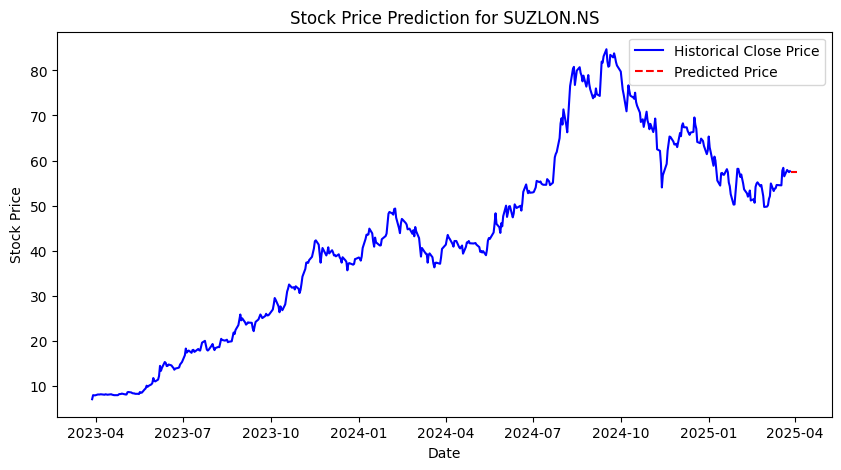

Predicted Prices for Next 7 Days:
2025-03-28: ₹57.49
2025-03-29: ₹57.49
2025-03-30: ₹57.49
2025-03-31: ₹57.49
2025-04-01: ₹57.49
2025-04-02: ₹57.49
2025-04-03: ₹57.49


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Function to get stock data
def get_stock_data(stock_symbol, period="2y", interval="1d"):
    stock = yf.download(stock_symbol, period=period, interval=interval, auto_adjust=True)
    if stock.empty:
        print(f"⚠️ No data found for {stock_symbol}. Check the ticker symbol.")
        return None
    stock['Return'] = stock['Close'].pct_change()
    stock.dropna(inplace=True)
    return stock

# Function to train a stock price prediction model
def train_model(stock_data):
    stock_data['Date'] = stock_data.index
    stock_data['Date'] = stock_data['Date'].map(pd.Timestamp.toordinal)  # Convert dates to numerical values

    X = stock_data[['Date', 'Open', 'High', 'Low', 'Volume']]
    y = stock_data['Close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    error = mean_absolute_error(y_test, y_pred)
    print(f"Model Error: {error:.2f}")
    return model

# Function to predict future stock prices
def predict_future_price(model, stock_data, days=5):
    last_date = stock_data.index[-1]
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, days + 1)]
    future_ordinal = [date.toordinal() for date in future_dates]

    last_known_data = stock_data.iloc[-1][['Open', 'High', 'Low', 'Volume']].values.reshape(1, -1)
    future_predictions = []

    for date in future_ordinal:
        future_input = np.insert(last_known_data, 0, date).reshape(1, -1)
        future_price = model.predict(future_input)[0]
        future_predictions.append((date, future_price))

    return future_dates, [price for _, price in future_predictions]

# Example Usage
stock_symbol = "SUZLON.NS"  # Suzlon stock on NSE
stock_data = get_stock_data(stock_symbol)
if stock_data is not None:
    model = train_model(stock_data)
    future_dates, future_prices = predict_future_price(model, stock_data, days=7)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(stock_data.index, stock_data['Close'], label="Historical Close Price", color='blue')
    plt.plot(future_dates, future_prices, label="Predicted Price", color='red', linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.title(f"Stock Price Prediction for {stock_symbol}")
    plt.show()

    print("Predicted Prices for Next 7 Days:")
    for date, price in zip(future_dates, future_prices):
        print(f"{date.strftime('%Y-%m-%d')}: ₹{price:.2f}")
